In [14]:
# Download and extract model
# ! wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/models/pytorch/resnet50_128_pytorch.tar.gz
# ! mkdir model
# ! tar -xvzf resnet50_128_pytorch.tar.gz -C model

In [9]:
# We will need this
# ! pip3 install gdown
# ! pip3 install shutil
# ! pip3 install tqdm
# ! sudo apt install unzip

In [16]:
# Download names
# ! mkdir data
# ! gdown https://drive.google.com/uc?id=1zRtJzbwomoRVQg5oFr621zpI0-4MnIFk
# ! mv names.tsv ./data/

In [15]:
# Download data
# ! gdown https://drive.google.com/uc?id=1jvjeTj8bJDpHvq6pJYlfxGnlLEKAHAxO
# ! mkdir data/test
# ! unzip test.zip -d data/test

In [1]:
import PIL
import torch
import glob as gb
import numpy as np
from PIL import Image
import pandas as pd
import os
import pylab as plt
import model.resnet50_128 as model

from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import shutil

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

In [3]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face

In [4]:
from pytorch_feature_extractor import initialize_model, image_encoding

CUDA is available!  Training on GPU ...


In [5]:
base_folder = '/home/care1e55/study/MIPT/cv/data/'
folder1 = base_folder + 'folder1/'
folder2 = base_folder + 'folder2/'
test_folder = base_folder + 'test_data/test_data/'
names_file = base_folder + 'class_mapping.csv'

# !mkdir '/home/care1e55/study/MIPT/cv/data/folder1/' & mkdir '/home/care1e55/study/MIPT/cv/data/folder2/'

In [6]:
names_file

'/home/care1e55/study/MIPT/cv/data/class_mapping.csv'

In [7]:
# names_file = '/home/care1e55/study/MIPT/cv/data/class_mapping.csv'
names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: test_folder+f'{x}')

In [8]:
names.head()

,image,class
0,/home/care1e55/study/MIPT/cv/data/test_data/te...,0
1,/home/care1e55/study/MIPT/cv/data/test_data/te...,1
2,/home/care1e55/study/MIPT/cv/data/test_data/te...,2
3,/home/care1e55/study/MIPT/cv/data/test_data/te...,3
4,/home/care1e55/study/MIPT/cv/data/test_data/te...,4


In [9]:
# prepare datasets for testing
sample = []
for i in range(500):
    row = names[names['class'] == i].iloc[0]
    sample.append((row['class'], row['image']))

# move 1 image from each class for prediction
for i in sample:
    shutil.copy(i[1], folder1+i[1].split('/')[-1])


In [10]:
images1 = gb.glob(folder1 + '*.jpg')
images2 = gb.glob(folder2 + '*.jpg')

In [11]:
print(folder1)
print(folder2)
print(len(images1))
print(len(images2))

/home/care1e55/study/MIPT/cv/data/folder1/
/home/care1e55/study/MIPT/cv/data/folder2/
500
115


In [12]:
IMAGE_SIZE = 160

In [13]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
# mtcnn = MTCNN(
#     image_size=160,
#     device=device
# )
mtcnn = MTCNN(
    image_size=IMAGE_SIZE,
    device=device,
    select_largest=False,
    selection_method = "center_weighted_size",
    # post_process=False,
    margin = 14,
    # min_face_size = 20,
)

Running on device: cuda:0


In [45]:
workers = 4
batch_size = 4

data_dir = '/home/care1e55/study/MIPT/cv/data/croped/mapping/'

folder1_dataset = ImageFolder(data_dir)

folder1_dataset.samples = [
    (p, p)
    for p, _ in tqdm(folder1_dataset.samples)
]

folder1_loader = DataLoader(
    folder1_dataset,
    num_workers=workers,
    # batch_size=batch_size,
    collate_fn=training.collate_pil
)

100%|██████████| 500/500 [00:00<00:00, 53290.78it/s]


In [20]:
folder1_dataset[2]

(<PIL.Image.Image image mode=RGB size=184x210 at 0x7F09C7520390>,
 '/home/care1e55/study/MIPT/cv/data/croped/mapping/10/141810.jpg')

In [17]:
for i in folder1_loader:
    print(i)
    break

([<PIL.Image.Image image mode=RGB size=275x306 at 0x7F403CB92208>], ['/home/care1e55/study/MIPT/cv/data/croped/mapping/0/107038.jpg'])


In [41]:
crop_paths = []
box_probs = []

for i, (x, b_paths) in tqdm(enumerate(folder1_loader), total=len(folder1_loader)):
    crops = [p.replace(data_dir, data_dir) for p in b_paths]
    mtcnn(x, save_path=crops)
    crop_paths.extend(crops)
    # print('\rBatch {} of {}'.format(i + 1, len(folder1_loader)), end='')

100%|██████████| 500/500 [00:12<00:00, 40.13it/s]


In [48]:
workers = 8
batch_size = 4

data_dir = '/home/care1e55/study/MIPT/cv/data/croped/test_data/'

test_dataset = ImageFolder(data_dir)

test_dataset.samples = [
    (p, p)
    for p, _ in tqdm(test_dataset.samples)
]

test_loader = DataLoader(
    test_dataset,
    num_workers=workers,
    # batch_size=batch_size,
    collate_fn=training.collate_pil
)

100%|██████████| 169396/169396 [00:00<00:00, 3983440.07it/s]


In [49]:
crop_paths = []
box_probs = []

for i, (x, b_paths) in tqdm(enumerate(test_loader), total=len(test_loader)):
    crops = [p.replace(data_dir, data_dir) for p in b_paths]
    try:
        mtcnn(x, save_path=crops)
    except:
        pass
    crop_paths.extend(crops)

100%|██████████| 169396/169396 [1:09:42<00:00, 40.50it/s]


In [ ]:

# Remove mtcnn to reduce GPU memory usage
del mtcnn
torch.cuda.empty_cache()

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [14]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
resnet = InceptionResnetV1(pretrained='vggface2', classify=False).to(device)
resnet.eval()
print()

In [69]:
trans = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    # np.float32,

    transforms.ToTensor(),
    fixed_image_standardization
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # fixed_image_standardization
])

TypeError: rsub() received an invalid combination of arguments - got (Tensor, ToTensor), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


In [22]:
workers = 4
batch_size = 4

def collate_fn(x):
    return x[0]

folder1_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/croped/mapping/', transform=trans)
# folder1_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/croped/mapping/')

folder1_dataset.idx_to_class = {i:c for c, i in folder1_dataset.class_to_idx.items()}
folder1_loader = DataLoader(folder1_dataset, collate_fn=collate_fn, num_workers=workers)

In [23]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [24]:
folder1_aligned = []
folder1_paths = []
folder1_names = []
for x, y, p in tqdm(folder1_loader):
    # print(x)
    # x_aligned, prob = mtcnn(x, return_prob=True)
    # if x_aligned is not None:
    folder1_aligned.append(x)
    folder1_names.append(y)
    folder1_paths.append(p)

100%|██████████| 500/500 [00:00<00:00, 1152.11it/s]


In [25]:
batch_size = 4
imgchunks = list(chunks(folder1_aligned, batch_size))
mapping_embeddings = []
for i, imgs in tqdm(enumerate(imgchunks), total=len(imgchunks)):
    stacked = torch.stack(imgs).to(device)
    mapping_embeddings += resnet(stacked).detach().cuda()
mapping_embeddings = torch.stack(mapping_embeddings).to(device)

100%|██████████| 125/125 [00:02<00:00, 44.07it/s]


In [26]:
# folder1_names

In [27]:
batch_size = 64

def collate_fn(x):
    return x

test_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/croped/test_data/', transform=trans)
test_dataset.idx_to_class = {i:c for c, i in test_dataset.class_to_idx.items()}
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, num_workers=workers, batch_size=batch_size)

In [23]:
test_dataset[133][0].size()

torch.Size([3, 160, 160])

In [24]:
folder1_dataset[137][0].size()

torch.Size([3, 160, 160])

In [25]:
len(test_paths)

NameError: name 'test_paths' is not defined

In [21]:
# for i in test_loader:
#     batch = i
#     break

In [22]:
# batch

In [23]:
# for i in folder1_loader:
#     print(i)
#     # break

In [28]:
predictions = []
# batch_size = 32
for batch in tqdm(test_loader):
    test_aligned = []
    test_paths = []
    for x, y, p in batch:
        # x_aligned, prob = mtcnn(x, return_prob=True)
        # if x_aligned is None:
            # x_aligned = x
        # test_aligned.append(x_aligned)
        test_aligned.append(x)
        test_paths.append(p)

    batch_embeddings = []
    imgchunks = list(chunks(test_aligned, batch_size))
    for i, imgs in enumerate(imgchunks):
        try:
            stacked = torch.stack(imgs).to(device)
        except:
            for k in imgs:
                print(k.size())
            break
        batch_embeddings += resnet(stacked).detach().cuda()
    batch_embeddings = torch.stack(batch_embeddings).to(device)
    # pred_idxs = torch.argmin(torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0), 1)
    pred_idxs = torch.argmax(torch.mm(batch_embeddings.detach(), mapping_embeddings.T.detach()), 1)
    batch_preds = list(map(folder1_paths.__getitem__, pred_idxs))
    predictions += [j for j in zip([i[2] for i in batch], batch_preds)]
# batch_prediction_dataset = [(i.split('/')[-1].split('.')[0], i.split('/')[-2]) for i in batch_preds]
# predictions += batch_prediction_dataset

100%|██████████| 2647/2647 [10:58<00:00,  4.02it/s]


In [284]:
# pd.DataFrame(predictions, header = ['',''])

In [46]:
len(predictions)

169396

In [50]:
batch_embeddings.size()

torch.Size([52, 512])

In [59]:
torch.mean(torch.cat((mapping_embeddings, batch_embeddings)))

tensor(-0.0004, device='cuda:0')

In [61]:
torch.mean(batch_embeddings)

tensor(-0.0002, device='cuda:0')

In [63]:
from torch.nn import CosineSimilarity

In [66]:
cos = CosineSimilarity(dim=0,eps=1e-6)

In [ ]:
# mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)

In [73]:
torch.argmin(torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0), 1)

tensor([ 96,  24, 230,  80,  59, 426, 119, 422, 406, 364, 151, 392, 447, 409,
        229, 235, 336, 329,  68,  95, 425, 455, 332, 429, 285, 284, 212, 381,
        319,  95, 445,  18, 300, 275, 353, 441, 102, 202, 288, 455, 397,   9,
        166, 318,  87, 391,  29, 391, 127, 237, 147, 247], device='cuda:0')

In [86]:
torch.argmax(torch.mm(batch_embeddings.detach(), mapping_embeddings.T.detach()), 1)

tensor([ 96,  24, 230,  80,  59, 426, 119, 422, 406, 364, 151, 392, 447, 409,
        229, 235, 336, 329,  68,  95, 425, 455, 332, 429, 285, 284, 212, 381,
        319,  95, 445,  18, 300, 275, 353, 441, 102, 202, 288, 455, 397,   9,
        166, 318,  87, 391,  29, 391, 127, 237, 147, 247], device='cuda:0')

In [76]:
torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0).size()

torch.Size([52, 500])

In [79]:
print(batch_embeddings.size())
print(mapping_embeddings.size())
print(mapping_embeddings.T.size())

torch.Size([52, 512])
torch.Size([500, 512])
torch.Size([512, 500])


In [81]:
torch.mm(batch_embeddings, mapping_embeddings.T).size()

torch.Size([52, 500])

In [72]:
# torch.dot(batch_embeddings.detach(), mapping_embeddings.T.detach())

RuntimeError: 1D tensors expected, got 2D, 2D tensors at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:16

In [82]:
torch.argmin(torch.mm(batch_embeddings.detach(), mapping_embeddings.T.detach()), 1)

tensor([272,  97,  53, 363,  86,  25, 306, 357, 174, 187, 470, 254,  64, 199,
        181, 130, 251,   6, 432, 300,  74,  74, 297, 190,  25, 490, 170, 360,
         29, 186,   6, 449,  22,  63, 171,  32, 428, 432, 306,  15, 480, 252,
        251, 203, 276, 271, 357, 251,   9, 169, 209, 217], device='cuda:0')

In [62]:
batch_embeddings.detach().norm(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [64]:
batch_embeddings[0]

tensor([ 0.0384, -0.0300,  0.0656, -0.0123,  0.0173,  0.1232, -0.0099,  0.0229,
         0.0231, -0.0118, -0.0396, -0.0354,  0.0544,  0.0492, -0.0285,  0.0039,
        -0.0329, -0.0415,  0.0300, -0.0502, -0.0267, -0.0191, -0.0006, -0.0081,
         0.0341,  0.0757, -0.0407, -0.0083,  0.0109, -0.0381, -0.0167,  0.0552,
         0.0104,  0.0164,  0.0171,  0.0047,  0.0409,  0.0033, -0.0347, -0.0177,
         0.0840, -0.0300, -0.0572,  0.0167,  0.0046, -0.0134, -0.0026, -0.0022,
         0.0171, -0.0816, -0.0119, -0.0546, -0.0348, -0.0123, -0.0095,  0.0453,
         0.0137, -0.0269,  0.0397, -0.0370, -0.0030, -0.0794, -0.0521, -0.0376,
        -0.0705,  0.0020,  0.0335,  0.0267, -0.0168, -0.0272,  0.0121, -0.0333,
        -0.0188,  0.0317,  0.0558,  0.0118,  0.0208,  0.0637, -0.0437, -0.0516,
         0.0104, -0.0050,  0.0287, -0.0111, -0.0324,  0.0443,  0.0711, -0.0390,
        -0.0005,  0.0035, -0.0296, -0.0365,  0.0023,  0.0622,  0.0287, -0.0061,
         0.0163, -0.0411, -0.0522,  0.05

In [226]:
pred_idxs = torch.argmin(torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0), 1)

In [279]:
batch_preds = list(map(folder1_paths.__getitem__, pred_idxs))

In [280]:
[(i.split('/')[-1].split('.')[0], i.split('/')[-2]) for i in batch_preds]

[('039324', '228'), ('052329', '1'), ('050760', '2'), ('080997', '3')]

In [299]:
batch_preds

['/home/care1e55/study/MIPT/cv/data/mapping/228/039324.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/2/050760.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/3/080997.jpg']

In [307]:
[j for j in zip([i[2] for i in batch], batch_preds)]

[('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000000.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/228/039324.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000001.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000002.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/2/050760.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000003.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/3/080997.jpg')]

In [255]:
[(i, i.split('/')[-2]) for i in batch_preds]

[('/home/care1e55/study/MIPT/cv/data/mapping/228/039324.jpg', '228'),
 ('/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg', '1'),
 ('/home/care1e55/study/MIPT/cv/data/mapping/2/050760.jpg', '2'),
 ('/home/care1e55/study/MIPT/cv/data/mapping/3/080997.jpg', '3')]

In [203]:
list(map(folder1_names.__getitem__, pred_idxs))

[144, 1, 112, 223]

In [206]:
folder1_names[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [207]:
folder1_paths[:10]

['/home/care1e55/study/MIPT/cv/data/mapping/0/107038.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/10/141810.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/100/134240.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/101/105748.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/102/140687.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/103/108057.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/104/015884.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/105/132651.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/106/032012.jpg']

In [168]:
pred_idxs = torch.argmin(torch.cdist(batch_embeddings.detach(), mapping_embeddings.detach(), p=2.0), 1)

In [169]:
pred_idxs

tensor([144,   1, 112, 223], device='cuda:0')

In [170]:
list(map(folder1_paths.__getitem__, pred_idxs))

['/home/care1e55/study/MIPT/cv/data/mapping/228/039324.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/2/050760.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/3/080997.jpg']

In [171]:
list(map(folder1_paths.__getitem__, pred_idxs))

['/home/care1e55/study/MIPT/cv/data/mapping/228/039324.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/2/050760.jpg',
 '/home/care1e55/study/MIPT/cv/data/mapping/3/080997.jpg']

In [180]:
list(map(lambda x: folder1_dataset.class_to_idx[str(x)], pred_idxs.tolist()))

[51, 1, 16, 139]

In [ ]:
list(map(lambda x: folder1_dataset.class_to_idx[str(x)], pred_idxs.tolist()))

In [256]:
# folder1_dataset.class_to_idx

In [111]:
# from shutil import copyfile

In [ ]:
# import shutil

In [119]:
# base_dir = "/home/care1e55/study/MIPT/cv/data/mapping/"
# for i in names.iterrows():
#     img_name = os.path.split(i[1][0])[1]
#     print(img_name, i[1][0], i[1][1])
#     dest_dir = os.path.join(base_dir, str(i[1][1]))
#     dest_img = os.path.join(dest_dir, img_name)
#     print(dest_dir, dest_img)
#     os.makedirs(dest_dir, exist_ok=True)
#     shutil.copyfile(i[1][0], dest_img)
#     # break

e/care1e55/study/MIPT/cv/data/mapping/390/085922.jpg
053860.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/053860.jpg 391
/home/care1e55/study/MIPT/cv/data/mapping/391 /home/care1e55/study/MIPT/cv/data/mapping/391/053860.jpg
024672.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/024672.jpg 392
/home/care1e55/study/MIPT/cv/data/mapping/392 /home/care1e55/study/MIPT/cv/data/mapping/392/024672.jpg
109025.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/109025.jpg 393
/home/care1e55/study/MIPT/cv/data/mapping/393 /home/care1e55/study/MIPT/cv/data/mapping/393/109025.jpg
043901.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/043901.jpg 394
/home/care1e55/study/MIPT/cv/data/mapping/394 /home/care1e55/study/MIPT/cv/data/mapping/394/043901.jpg
125047.jpg /home/care1e55/study/MIPT/cv/data/test_data/test_data/125047.jpg 395
/home/care1e55/study/MIPT/cv/data/mapping/395 /home/care1e55/study/MIPT/cv/data/mapping/395/125047.jpg
009675.jpg /home/care1e55/study/

In [59]:
for i in folder1_loader:
    print(i)
    break

(<PIL.Image.Image image mode=RGB size=169x193 at 0x7FAD40ABC550>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001625.jpg')


In [ ]:
test_dataset = ImageFolderWithPaths('/home/care1e55/study/MIPT/cv/data/test_data/')
test_dataset.idx_to_class = {i:c for c, i in test_dataset.class_to_idx.items()}
test_loader = DataLoader(test_dataset, collate_fn=collate_fn, num_workers=workers)

In [37]:
len(folder1_loader)

125

In [39]:
for i in folder1_loader:
    print(i)
    break

[(<PIL.Image.Image image mode=RGB size=169x193 at 0x7FAD4C3A4E48>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001625.jpg'), (<PIL.Image.Image image mode=RGB size=196x218 at 0x7FAD4C3A4D30>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001729.jpg'), (<PIL.Image.Image image mode=RGB size=166x190 at 0x7FAD4C3A45C0>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/001939.jpg'), (<PIL.Image.Image image mode=RGB size=292x310 at 0x7FAD4C3A4B38>, 0, '/home/care1e55/study/MIPT/cv/data/folder1_images/sub/002441.jpg')]


In [62]:
folder1_aligned = []
folder1_names = []
folder1_paths = []
for x, y, p in tqdm(folder1_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        folder1_aligned.append(x_aligned)
        folder1_names.append(dataset.idx_to_class[y])
        folder1_paths.append(p)

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'dataset' is not defined

In [44]:
folder1_aligned = []
folder1_paths = []
for x, y, p in tqdm(folder1_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        folder1_aligned.append(x_aligned)
        folder1_paths.append(p)

100%|██████████| 500/500 [00:10<00:00, 45.92it/s]


In [127]:
test_aligned = []
test_names = []
test_paths = []
for x, y, p in tqdm(test_loader):
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        # print('Face detected with probability: {:8f}'.format(prob))
        test_aligned.append(x_aligned)
        test_names.append(dataset.idx_to_class[y])
        test_paths.append(p)

  0%|          | 633/169396 [00:13<1:10:58, 39.63it/s]Process Process-41:
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f89b8715668>>
Traceback (most recent call last):
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/care1e55/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
  0%|          | 633/169396 [00:14<1:06:28, 42.31it/s]Traceback (mos

KeyboardInterrupt: 

In [103]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=127x159 at 0x7F89B898AF98>,
 0,
 '/home/care1e55/study/MIPT/cv/data/folder2_images/sub/168504.jpg')

In [46]:
batch_size = 4
imgchunks = list(chunks(folder1_aligned, batch_size))

In [47]:
embeddings = []
for i, imgs in tqdm(enumerate(imgchunks), total=len(imgchunks)):
    stacked = torch.stack(imgs).to(device)
    embeddings += resnet(stacked).detach().cuda()
embeddings = torch.stack(embeddings).to(device)

100%|██████████| 125/125 [00:04<00:00, 31.08it/s]


In [115]:
pred_idxs = torch.argmin(torch.cdist(embeddings.detach(), embeddings.detach(), p=2.0), 1)

In [121]:
# list(map(paths.__getitem__, pred_idxs))

In [292]:
predictions[2][0]

'/'

In [322]:
predictions

[('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000000.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/228/039324.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000001.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/1/052329.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000002.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/2/050760.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000003.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/3/080997.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000004.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/463/108600.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000005.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/314/129997.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000006.jpg',
  '/home/care1e55/study/MIPT/cv/data/mapping/6/019905.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/test_data/test_data/000007.jpg',
  '/hom

In [294]:
def predict(folder1:str, folder2:str) -> list:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(folder2 + '*.jpg')
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)
    
    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return [(images2[i], images1[images.argmax()]) for i, images in enumerate(S)]

In [295]:
def predict_once(folder1:str, image2:str) -> str:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(image2)
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)

    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return images1[S.argmax()]

In [296]:
# small test
# (240, 224, 3)
# folder2 = '/home/care1e55/study/MIPT/cv/data/test_data/test_data/'
predictions = predict(folder1, folder2)

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


In [297]:
predictions[:10]

[('/home/care1e55/study/MIPT/cv/data/folder2/168594.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/027595.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168598.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/059721.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168509.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/106279.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168568.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/018638.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168577.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/090741.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168618.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/078140.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168515.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/022153.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168529.jpg',
  '/home/care1e55/study/MIPT/cv/data/folder1/018917.jpg'),
 ('/home/care1e55/study/MIPT/cv/data/folder2/168557.jpg',
  '/ho

In [14]:
# big test
predictions = predict(folder1, test_folder)

100%|██████████| 10556/10556 [1:25:35<00:00,  2.06it/s]


In [44]:
import pickle
with open('predictions_facenet.pickle', 'wb') as f:
    pickle.dump(predictions, f)

In [71]:
prediction = predict_once(folder1, 'data/test/folder2/1.jpg')
prediction

100%|██████████| 1/1 [00:00<00:00, 53.37it/s]


'data/test/folder1/0.jpg'

In [60]:
# names = pd.read_csv(names_file, delimiter='\t', names=['class', 'image'])

In [29]:
names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: x.split('.')[0])

In [30]:
names

,image,class
0,107038,0
1,052329,1
2,050760,2
3,080997,3
4,113304,4
...,...,...
495,151916,495
496,160470,496
497,126103,497
498,006945,498


In [31]:
names[names['image'] == str(107038)]

,image,class
0,107038,0


In [32]:
# predictions

In [33]:
class FaceImagesClassDataset(Dataset):
    """
    Images Dataset only for printing
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        predicted = self._prepare_sample(self.load_sample(self.predictions[index][0]))
        source = self._prepare_sample(self.load_sample(self.predictions[index][1]))
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        # print(source_num, predicted_num, names[names['image'] == str(predicted_num)])

        # source_class = names[names['image'] == str(source_num)]['class'].iloc[0]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        # predicted_class, source_class = 0, 0
        # return predicted, source, predicted_class, source_class
        return predicted, source, predicted_class, predicted_class
    

In [34]:
face_images_class_dataset = FaceImagesClassDataset(predictions, names)

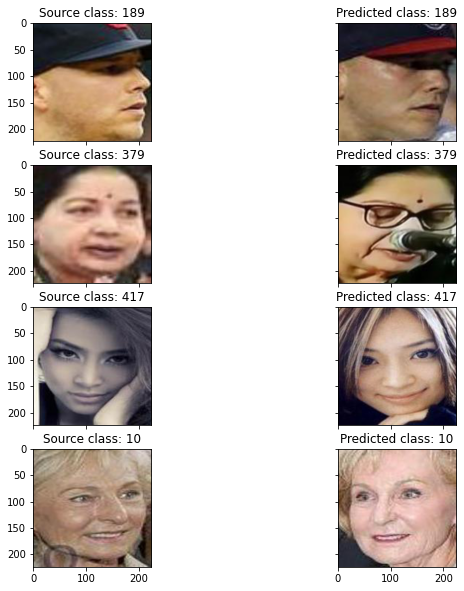

In [56]:
Ni = 4
RESCALE_SIZE = 224

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in range(Ni):
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(predictions)))
        source, predicted, source_class, predicted_class = face_images_class_dataset[random_characters]
        
        ax[i ,0].imshow(source)
        ax[i ,0].set_title('Source class: ' + str(source_class))
        ax[i ,1].imshow(predicted)
        ax[i ,1].set_title('Predicted class: ' + str(predicted_class))

In [41]:
class FaceClassDataset(Dataset):
    """
    Class Dataset only for accuracy score 
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        
        # source_class = names[names['image'] == int(source_num)]['class'].iloc[0]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        
        return str(source_num)+'.jpg', predicted_class
    

In [42]:
face_class_dataset = FaceClassDataset(predictions, names)

In [43]:
final_preds = []
for i, face_pair in tqdm(
    enumerate(face_class_dataset), 
    total = len(face_class_dataset)
):
    final_preds.append(face_pair)
    # print(face_pair)

100%|██████████| 169396/169396 [01:19<00:00, 2143.51it/s]


In [39]:
final_preds[0]

('000000.jpg', 228)

In [40]:
len(final_preds)

169214

In [44]:
pd.DataFrame(final_preds).to_csv('facenet_preds_margin_2.csv', header=['Id', 'random'], index=None)

In [97]:
def face_accuracy(face_class_dataset):
    acum = 0
    for i, face_pair in tqdm(enumerate(face_class_dataset), 
                             total = len(face_class_dataset)):
        acum += int(face_pair[0] == face_pair[1])
    return acum/len(predictions)

face_accuracy(face_class_dataset)

  0%|          | 0/115 [00:00<?, ?it/s]


0.0